In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from linearmodels import IV2SLS
from linearmodels.iv.results import compare

C:\Users\yezon\AppData\Local\Temp\ipykernel_8864\3704518870.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [60]:
# Load the data
data = pd.read_csv('../../data/combined_data/gvcomix_data.csv')
# Drop rows with missing values in any of the columns used in the regression
columns_to_check = ['milexp_pergdpSIPRI', 'decade', 'logpopdens_diff', 
                    'ecgrowth_demeaned', 'democracy_diff',
                    'oilreserves', 'logmountain', 'ethnic_fractionalization', 'trans_outp_p']
# Replace infinite values with NaN
data[columns_to_check] = data[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in these columns
data = data.dropna(subset=columns_to_check)

data = data.set_index(['country', 't'])

Oil Reserves Clustering, KMeans clustering using the variables chosen from LASSO

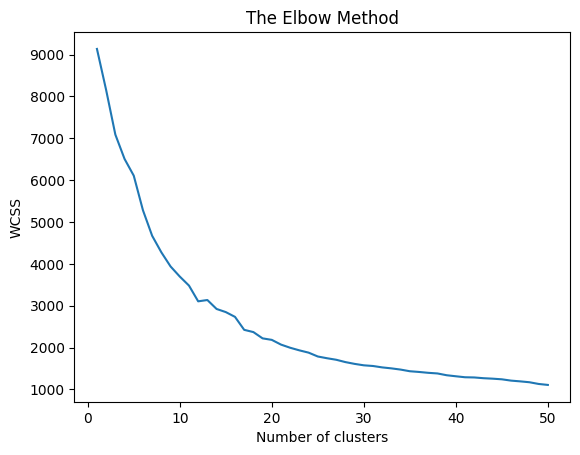

In [61]:

features = data[['oilreserves', 'milexp_pergdpSIPRI', 'decade', 'logpopdens_diff' , 'ecgrowth_demeaned', 'democracy_diff',
                 'logmountain', 'ethnic_fractionalization']]  

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating WCSS for a range of number of clusters
wcss = []
for i in range(1, 51):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.plot(range(1, 51), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We see rough elbow at K = 17

regress mil exp on oil resserves using clustering


In [62]:
# Step 1: Clusters
kmeans = KMeans(n_clusters=18, random_state=0)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Step 2: Run Regression Analysis with Cluster Dummies
# Define the model formula including cluster dummies
formula = 'milexp_pergdpSIPRI ~ oilreserves + decade + logpopdens_diff + ecgrowth_demeaned + democracy_diff + logmountain + language_fractionalization + C(Cluster)'

# Fit the model
model = smf.ols(formula, data=data).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     milexp_pergdpSIPRI   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     113.2
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.14e-269
Time:                        17:02:51   Log-Likelihood:                -1979.9
No. Observations:                1116   AIC:                             4008.
Df Residuals:                    1092   BIC:                             4128.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [6]:
# Group by 'Cluster' and then aggregate the unique countries in each cluster
clustered_countries = data.groupby('Cluster').apply(lambda x: x.index.get_level_values('country').unique())

# Print the countries in each cluster
for cluster_id, countries in clustered_countries.items():
    print(f"Cluster {cluster_id}: {', '.join(countries)}")


Cluster 0: IRN, VEN, RUS
Cluster 1: BRA, CAN, CHE, CMR, DJI, DOM, DZA, EGY, GIN, KEN, MNG, NIC, RWA, SLE, UGA, USA, AGO, CAF, MOZ, MWI, TZA, ZMB, ZWE, MLI, NAM, PAK, TCD, NGA, TUR, BDI, MEX, JAM, LAO, COL, SYR, THA, ECU, MYS, PER, MDG
Cluster 2: ARE, BFA, BHR, BWA, GMB, KWT, MRT, SGP, COG, SEN, TGO
Cluster 3: ARE, BFA, BHR, BWA, GMB, MRT, SEN, SGP, TGO, KWT
Cluster 4: KWT
Cluster 5: ARG, AUS, AUT, AZE, BDI, CHL, CHN, CRI, DEU, DOM, DZA, EGY, FIN, GBR, HND, IND, ITA, JAM, KHM, KOR, LKA, LSO, MNG, NOR, PRT, PRY, RWA, SLV, SWZ, TUN, TUR, ZWE, USA
Cluster 6: SAU
Cluster 7: MDG, ZMB, MNG, THA, CAF, LSO, MOZ, MWI, SLE, IRN, KHM, DJI, IDN, NER, SEN, KEN
Cluster 8: OMN, SYR, LBR, KWT, ZWE
Cluster 9: AGO, BOL, CAF, COL, ECU, IDN, MEX, MOZ, MWI, MYS, NAM, NGA, NPL, PAK, PAN, PER, THA, TZA, CAN, DOM, GIN, SYR, UGA, USA, BRA, MDG, SLE, ZMB, CHE, KEN, MLI, NER, NIC, TCD, CMR, DJI, LAO
Cluster 10: ARG, AUS, AUT, BDI, CHL, CHN, CRI, DEU, FIN, GBR, IND, ITA, JAM, KHM, KOR, LKA, LSO, NOR, PRT, PRY, SLV

C:\Users\yezon\AppData\Local\Temp\ipykernel_8864\3172114636.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clustered_countries = data.groupby('Cluster').apply(lambda x: x.index.get_level_values('country').unique())


GVC MIX, IV Elbow

In [40]:
# Load the data
data = pd.read_csv('../../data/combined_data/gvcomix_data.csv')
# Drop rows with missing values in any of the columns used in the regression
columns_to_check = ['milexp_pergdpSIPRI', 'decade', 'logpopdens_diff', 
                    'ecgrowth_demeaned', 'democracy_diff',
                    'logmountain', 'ethnic_fractionalization', 'trans_outp_p']
# Replace infinite values with NaN
data[columns_to_check] = data[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in these columns
data = data.dropna(subset=columns_to_check)

data = data.set_index(['country', 't'])

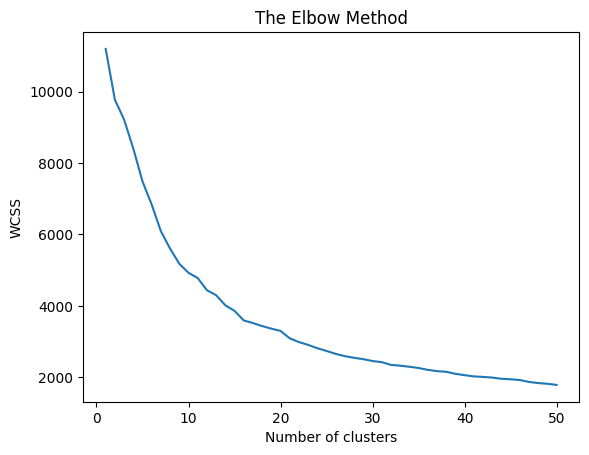

In [41]:

# relevant variables
features = data[['s6', 'milexp_pergdpSIPRI', 'decade', 'logpopdens_diff' , 'ecgrowth_demeaned', 'democracy_diff',
                 'logmountain', 'ethnic_fractionalization']]  

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating WCSS for a range of number of clusters
wcss = []
for i in range(1, 51):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.plot(range(1, 51), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


IV Clustering

In [42]:
kmeans = KMeans(n_clusters=21, random_state=0)
data['Cluster'] = kmeans.fit_predict(features_scaled)


In [43]:
formula = 'milexp_pergdpSIPRI ~ s6 + decade + logpopdens_diff + ecgrowth_demeaned + democracy_diff + logmountain + language_fractionalization + C(Cluster)'

# Fit the model
model = smf.ols(formula, data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     milexp_pergdpSIPRI   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     133.2
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:59:16   Log-Likelihood:                -2366.7
No. Observations:                1374   AIC:                             4787.
Df Residuals:                    1347   BIC:                             4928.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Forward GVC

In [44]:
# Load the data
data = pd.read_csv('../../data/combined_data/gvcofp_data.csv')
# Drop rows with missing values in any of the columns used in the regression
columns_to_check = ['milexp_pergdpSIPRI', 'decade', 'logpopdens_diff', 
                    'ecgrowth_demeaned', 'democracy_diff',
                    'logmountain', 'ethnic_fractionalization', 'trans_outp_p']
# Replace infinite values with NaN
data[columns_to_check] = data[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in these columns
data = data.dropna(subset=columns_to_check)

data = data.set_index(['country', 't'])

Elbow

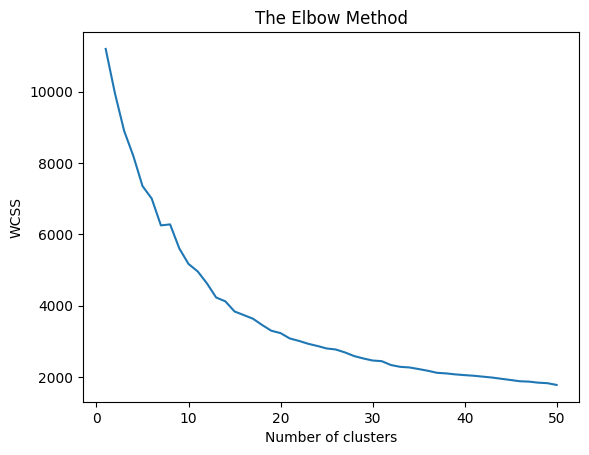

In [45]:

# relevant variables
features = data[['s6', 'milexp_pergdpSIPRI', 'decade', 'logpopdens_diff' , 'ecgrowth_demeaned', 'democracy_diff',
                 'logmountain', 'ethnic_fractionalization']]  

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating WCSS for a range of number of clusters
wcss = []
for i in range(1, 51):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.plot(range(1, 51), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [46]:
kmeans = KMeans(n_clusters=20, random_state=0)
data['Cluster'] = kmeans.fit_predict(features_scaled)


In [47]:
formula = 'milexp_pergdpSIPRI ~ s6 + decade + logpopdens_diff + ecgrowth_demeaned + democracy_diff + logmountain + language_fractionalization + C(Cluster)'

# Fit the model
model = smf.ols(formula, data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     milexp_pergdpSIPRI   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     115.9
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          6.13e-321
Time:                        16:59:36   Log-Likelihood:                -2434.2
No. Observations:                1374   AIC:                             4922.
Df Residuals:                    1347   BIC:                             5064.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [48]:
# Group by 'Cluster' and then aggregate the unique countries in each cluster
clustered_countries = data.groupby('Cluster').apply(lambda x: x.index.get_level_values('country').unique())

# Print the countries in each cluster
for cluster_id, countries in clustered_countries.items():
    print(f"Cluster {cluster_id}: {', '.join(countries)}")

Cluster 0: AUS, AUT, CHN, DEU, GBR, GRC, ITA, JPN, KOR, NOR, POL, PRT, SWE, TUN, EGY, SLV, BDI, BGR, FIN, SWZ, RUS, ARG, KHM, AZE, CHL, TWN
Cluster 1: ARE, BHR, BWA, SGP, KWT, TGO, RWA
Cluster 2: BOL, COL, ECU, GTM, IDN, IRN, MEX, MOZ, MWI, NGA, NPL, PAN, PER, THA, CAN, BRA, GIN, MDG, SLE, UGA, ZMB, CAF, KEN, MLI, NAM, NER, NIC, TCD, ZAF, AGO, CMR, CIV, COD, TZA, MYS
Cluster 3: BGD, MDG, ZMB, MNG, THA, TWN, CAF, LSO, MOZ, MWI, SLE, IRN, KHM, DJI, IDN, NER, SEN, KEN
Cluster 4: AGO, BOL, BRA, CAN, CHE, CMR, COD, COL, DJI, DOM, GAB, GIN, GTM, IDN, IRN, JOR, KEN, MAR, MDG, MEX, MLI, MMR, MOZ, MWI, MYS, NAM, NER, NGA, NIC, NPL, PAK, PAN, PER, SLE, SYR, TCD, THA, TJK, TZA, UGA, USA, VEN, ZAF, ECU, LAO, CAF, CIV, GEO, IND
Cluster 5: MDA
Cluster 6: KWT
Cluster 7: MUS, MMR, LAO, MDA
Cluster 8: BEL, BFA, GHA, GMB, MRT, MUS, SEN, TGO, BHR, MDA, SGP, BWA, BEN
Cluster 9: ISR, JOR, OMN, SAU, SYR, LBR, KWT, ZWE, BDI
Cluster 10: ARE, BEL, BEN, BFA, BHR, BWA, GHA, GMB, KWT, MRT, MUS, SGP, COG, SEN, MDA

C:\Users\yezon\AppData\Local\Temp\ipykernel_8864\2469337536.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clustered_countries = data.groupby('Cluster').apply(lambda x: x.index.get_level_values('country').unique())


Backwards GVC

In [49]:
# Load the data
data = pd.read_csv('../../data/combined_data/gvcobp_data.csv')
# Drop rows with missing values in any of the columns used in the regression
columns_to_check = ['milexp_pergdpSIPRI', 'decade', 'logpopdens_diff', 
                    'ecgrowth_demeaned', 'democracy_diff',
                    'logmountain', 'ethnic_fractionalization', 'trans_outp_p']
# Replace infinite values with NaN
data[columns_to_check] = data[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in these columns
data = data.dropna(subset=columns_to_check)

data = data.set_index(['country', 't'])

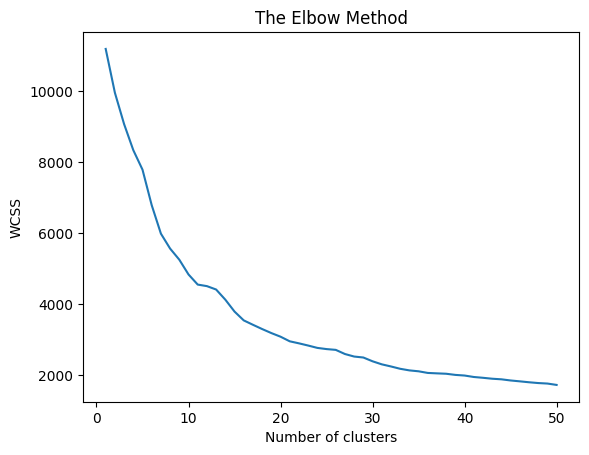

In [50]:

# relevant variables
features = data[['s6', 'milexp_pergdpSIPRI', 'decade', 'logpopdens_diff' , 'ecgrowth_demeaned', 'democracy_diff',
                 'logmountain', 'ethnic_fractionalization']]  

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating WCSS for a range of number of clusters
wcss = []
for i in range(1,51):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.plot(range(1, 51), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [51]:
kmeans = KMeans(n_clusters=21, random_state=0)
data['Cluster'] = kmeans.fit_predict(features_scaled)


In [52]:
formula = 'milexp_pergdpSIPRI ~ s6 + decade + logpopdens_diff + ecgrowth_demeaned + democracy_diff + logmountain + language_fractionalization + C(Cluster)'

# Fit the model
model = smf.ols(formula, data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     milexp_pergdpSIPRI   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     136.7
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:59:53   Log-Likelihood:                -2354.0
No. Observations:                1374   AIC:                             4762.
Df Residuals:                    1347   BIC:                             4903.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [53]:
# Group by 'Cluster' and then aggregate the unique countries in each cluster
clustered_countries = data.groupby('Cluster').apply(lambda x: x.index.get_level_values('country').unique())

# Print the countries in each cluster
for cluster_id, countries in clustered_countries.items():
    print(f"Cluster {cluster_id}: {', '.join(countries)}")

Cluster 0: ARG, AUS, AUT, CHL, CHN, CRI, DEU, GBR, GRC, ITA, JPN, KHM, KOR, NOR, PRT, PRY, SLV, SWE, SWZ, TUN, EGY, LSO, PHL, POL, BDI, FIN, TWN, AZE, RUS
Cluster 1: ARE, BEL, BEN, BFA, BHR, BWA, GHA, GMB, KWT, MRT, MUS, SGP, COG, SEN, MDA, TGO
Cluster 2: ARG, AUS, AUT, AZE, BDI, BGR, CHL, CHN, CRI, DEU, DOM, DZA, EGY, ESP, FIN, GBR, GEO, GRC, HND, IND, ITA, JAM, JPN, KHM, KOR, LKA, LSO, MNG, NOR, NZL, PHL, POL, PRT, PRY, RWA, SLV, SWE, SWZ, TUN, TUR, TWN, ZWE, RUS
Cluster 3: AGO, BOL, CAF, CAN, CIV, CMR, DJI, GIN, IRN, KEN, MOZ, MWI, NGA, TZA, UGA, ZAF, NIC, NPL, ZMB, MDG, MLI, NAM, PER, TCD, NER, SLE, ECU, COD, GTM, PAK
Cluster 4: KWT, PER, TGO, MWI, GEO, NIC, MMR, RUS, TJK, MLI, MOZ, SLE, AGO, CHN, MDG, NGA, TCD
Cluster 5: KWT
Cluster 6: BDI, IND, LSO, MAR, MYS, NAM, PAK, TUR, TWN, USA, ZWE, CHL, JOR, KHM, LKA, MMR, RWA, SYR, BGR, AGO, DZA, COL, LAO, TJK
Cluster 7: BGD, MDG, ZMB, MNG, THA, TWN, CAF, LSO, MOZ, MWI, SLE, IRN, KHM, DJI, IDN, NER, SEN, KEN
Cluster 8: IRL, COL, MDA
Clust

C:\Users\yezon\AppData\Local\Temp\ipykernel_8864\2469337536.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clustered_countries = data.groupby('Cluster').apply(lambda x: x.index.get_level_values('country').unique())
